# Multilingual NER Analysis

In [1]:
from gensim.models import KeyedVectors
from nltk.corpus.reader.conll import ConllCorpusReader
import re
from math import floor
import numpy as np
import sys
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from keras.layers.recurrent import LSTM
from keras.models import Sequential, Model
from keras.layers import Dense, Bidirectional, Flatten, Dropout, TimeDistributed
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
import keras.backend as K
from keras_contrib.layers import CRF
from keras_contrib.utils import save_load_utils
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Load the Data from File

In [3]:
X_en_train = np.load('data/eng.X.train.npy', mmap_mode='r')
y_en_train_label = np.load('data/eng.y.train.npy', mmap_mode='r')

In [4]:
X_en_test = np.load('data/eng.X.testa.npy', mmap_mode='r')
y_en_test_label = np.load('data/eng.y.testa.npy', mmap_mode='r')

In [5]:
X_de_test = np.load('data/deu.X.testa.npy', mmap_mode='r')
y_de_test_label = np.load('data/deu.y.testa.npy', mmap_mode='r')

In [6]:
X_de_train = np.load('data/deu.X.train.npy', mmap_mode='r')
y_de_train_label = np.load('data/deu.y.train.npy', mmap_mode='r')

In [7]:
X_es_test = np.load('data/esp.X.testa.npy', mmap_mode='r')
y_es_test_label = np.load('data/esp.y.testa.npy', mmap_mode='r')

In [8]:
X_es_train = np.load('data/esp.X.train.npy', mmap_mode='r')
y_es_train_label = np.load('data/esp.y.train.npy', mmap_mode='r')

### Encode the Target

In [9]:
train_en_classes = set()
for sent in y_en_train_label:
    for label in sent:
        train_en_classes.add(label)
        
test_en_classes = set()
for sent in y_en_test_label:
    for label in sent:
        test_en_classes.add(label)
        
train_de_classes = set()
for sent in y_de_train_label:
    for label in sent:
        train_de_classes.add(label)
        
test_de_classes = set()
for sent in y_de_test_label:
    for label in sent:
        test_de_classes.add(label)
        
train_es_classes = set()
for sent in y_es_train_label:
    for label in sent:
        train_es_classes.add(label)
        
test_es_classes = set()
for sent in y_es_test_label:
    for label in sent:
        test_es_classes.add(label)

classes = list(train_en_classes.union(test_en_classes.union(train_de_classes.union(test_de_classes.union(train_es_classes.union(test_es_classes))))))
print("Classes:", classes)
print("Missing in English training:", 
      test_en_classes.difference(train_en_classes),
      test_de_classes.difference(train_en_classes), 
      test_es_classes.difference(train_en_classes))
print("Missing in German training:", 
      test_en_classes.difference(train_de_classes),
      test_de_classes.difference(train_de_classes), 
      test_es_classes.difference(train_de_classes))

print("Missing in Spanish training:", 
      test_en_classes.difference(train_es_classes),
      test_de_classes.difference(train_es_classes), 
      test_es_classes.difference(train_es_classes))

num_classes = len(classes)
encoded_classes = range(num_classes)
class2idx = {classes[enc]: enc for enc in encoded_classes}


Classes: ['B-MISC', 'I-ORG', 'I-PER', 'O', 'I-LOC', 'B-ORG', 'B-PER', 'B-LOC', 'I-MISC']
Missing in English training: set() {'B-PER'} {'B-PER'}
Missing in German training: set() {'B-PER'} {'B-PER'}
Missing in Spanish training: set() set() set()


### Create a Binary Variation of the Task

In [10]:
def lab2bin(y_labels):
    y_bin = np.copy(y_labels)
    for i in range(len(y_bin)):
        for j in range(len(y_bin[i])):
            if y_bin[i][j] != 'O':
                if y_bin[i][j][0] == 'B':
                    y_bin[i][j] = 'B-NE'
                else:
                    y_bin[i][j] = 'I-NE'
    return y_bin

In [11]:
y_en_train_bin_label = lab2bin(y_en_train_label)              
y_en_test_bin_label = lab2bin(y_en_test_label)
 
y_de_train_bin_label = lab2bin(y_de_train_label)
y_de_test_bin_label = lab2bin(y_de_test_label)

y_es_train_bin_label = lab2bin(y_es_train_label)
y_es_test_bin_label = lab2bin(y_es_test_label)


bin_classes = ['O', 'B-NE', 'I-NE']
bin_num_classes = len(bin_classes)
bin_encoded_classes = range(bin_num_classes)
binclass2idx = {bin_classes[enc]: enc for enc in bin_encoded_classes}

### Convert the Labels to Categorical Arrays

In [12]:
y_en_train = np.array([np.array(to_categorical([class2idx[cls] for cls in sent], num_classes=num_classes)) for sent in y_en_train_label])
y_en_test = np.array([np.array(to_categorical([class2idx[cls] for cls in sent], num_classes=num_classes)) for sent in y_en_test_label])
y_de_train = np.array([np.array(to_categorical([class2idx[cls] for cls in sent], num_classes=num_classes)) for sent in y_de_train_label])
y_de_test = np.array([np.array(to_categorical([class2idx[cls] for cls in sent], num_classes=num_classes)) for sent in y_de_test_label])
y_es_train = np.array([np.array(to_categorical([class2idx[cls] for cls in sent], num_classes=num_classes)) for sent in y_es_train_label])
y_es_test = np.array([np.array(to_categorical([class2idx[cls] for cls in sent], num_classes=num_classes)) for sent in y_es_test_label])

y_en_train_bin = np.array([np.array(to_categorical([binclass2idx[cls] for cls in sent], num_classes=bin_num_classes)) for sent in y_en_train_bin_label])
y_en_test_bin = np.array([np.array(to_categorical([binclass2idx[cls] for cls in sent], num_classes=bin_num_classes)) for sent in y_en_test_bin_label])
y_de_train_bin = np.array([np.array(to_categorical([binclass2idx[cls] for cls in sent], num_classes=bin_num_classes)) for sent in y_de_train_bin_label])
y_de_test_bin = np.array([np.array(to_categorical([binclass2idx[cls] for cls in sent], num_classes=bin_num_classes)) for sent in y_de_test_bin_label])
y_es_train_bin = np.array([np.array(to_categorical([binclass2idx[cls] for cls in sent], num_classes=bin_num_classes)) for sent in y_es_train_bin_label])
y_es_test_bin = np.array([np.array(to_categorical([binclass2idx[cls] for cls in sent], num_classes=bin_num_classes)) for sent in y_es_test_bin_label])


### Combine the Languages

In [13]:
X_train = np.vstack([X_en_train, X_de_train, X_es_train])
y_train = np.vstack([y_en_train, y_de_train, y_es_train])
y_train_bin = np.vstack([y_en_train_bin, y_de_train_bin, y_es_train_bin])

In [14]:
np.save('data/full.X.train.npy', X_train)
np.save('data/full.y.train.npy', y_train)

## Create the Model

In [15]:
dropout = 0.1
recurrent_dropout = 0.3
window_size = X_en_train[0].shape[0]
num_features = X_en_train[0].shape[1]
hidden_nodes = 100

def create_model(num_classes, num_features, hidden_nodes=100):
    model = Sequential()
    model.add(Bidirectional(
        LSTM(units=num_features, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout),
        input_shape=(window_size, num_features,),
        merge_mode='concat'))
#     model.add(Dropout(dropout))
#     model.add(BatchNormalization())
    model.add(TimeDistributed(Dense(hidden_nodes, activation='relu')))
    # add a CRF layer to enforce NER IOB rules
    crf = CRF(num_classes, sparse_target=False)
    model.add(crf)
    print("Summary:", model.summary())
    model.compile(optimizer='rmsprop', loss=crf.loss_function, metrics=[crf.accuracy])
#     model.add(Dense(num_classes, activation='softmax'))
#     model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
print("X shape:", X_en_train.shape)
print("y shape:", y_en_train.shape)
model = create_model(num_classes, num_features)
model.fit(X_en_train, y_en_train, batch_size=50, epochs=10)

X shape: (11376, 70, 300)
y shape: (11376, 70, 9)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 70, 600)           1442400   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 70, 100)           60100     
_________________________________________________________________
crf_1 (CRF)                  (None, 70, 9)             1008      
Total params: 1,503,508
Trainable params: 1,503,508
Non-trainable params: 0
_________________________________________________________________
Summary: None
Epoch 1/10
11376/11376 [==============================] - 478s 42ms/step - loss: 0.1368 - acc: 0.9627
Epoch 2/10
11376/11376 [==============================] - 264s 23ms/step - loss: 0.0473 - acc: 0.9844
Epoch 3/10
11376/11376 [==============================] - 207s 18ms/step - loss: 0.0332 - acc: 0.9867
Epoch 4/10
11376/11376 [==

In [17]:
save_load_utils.save_all_weights(model,'models/eng_train.h5')

# Analysis

In [18]:
def arr2label(cats, labels):
    new_labels = []
    for i in range(len(cats)):
        sent_labels = []
        for j in range(len(cats[i])):
            label = np.argmax(cats[i][j])
            label = labels[label]
            new_labels.append(label)
    return new_labels

### English Results from English Training

2701/2701 [==============================] - 22s 8ms/step
loss: -0.00534905156073
acc: 0.990109483364


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: 0.755855649643
Recall: 0.691733510329
F1: 0.719749248647


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


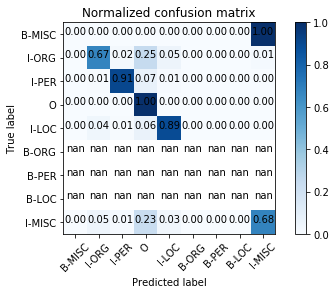

In [19]:
y_pred_en = model.predict(X_en_test)
score_en = model.evaluate(X_en_test, y_en_test)
for i in range(len(score_en)):
    print(str(model.metrics_names[i]) + ': ' + str(score_en[i]))
y_pred_en_label = arr2label(y_pred_en, classes)
y_true_en_label = arr2label(y_en_test, classes)

precision = precision_score(y_true_en_label, y_pred_en_label, average='macro')
recall = recall_score(y_true_en_label, y_pred_en_label, average='macro')
f1 = f1_score(y_true_en_label, y_pred_en_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_en_label, y_pred_en_label, labels=classes)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

### German Results from English Training

2644/2644 [==============================] - 21s 8ms/step
loss: 0.289653536727
acc: 0.877739360221


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: 0.175822842898
Recall: 0.302624726815
F1: 0.19467285714


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


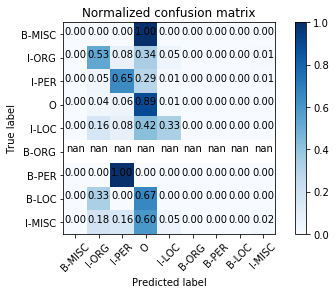

In [20]:
y_pred_de = model.predict(X_de_test)
score_de = model.evaluate(X_de_test, y_de_test)
for i in range(len(score_de)):
    print(str(model.metrics_names[i]) + ': ' + str(score_de[i]))
y_pred_de_label = arr2label(y_pred_de, classes)
y_true_de_label = arr2label(y_de_test, classes)

precision = precision_score(y_true_de_label, y_pred_de_label, average='macro')
recall = recall_score(y_true_de_label, y_pred_de_label, average='macro')
f1 = f1_score(y_true_de_label, y_pred_de_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_de_label, y_pred_de_label, labels=classes)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

### Spanish Results from English Training

1588/1588 [==============================] - 13s 8ms/step
loss: 0.661130970011
acc: 0.938745955226


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: 0.201326639388
Recall: 0.280856186692
F1: 0.224143056217


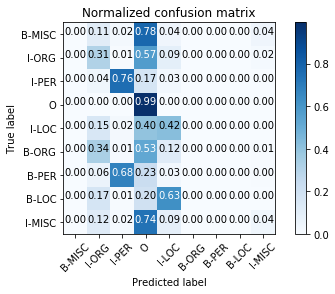

In [21]:
y_pred_es = model.predict(X_es_test)
score_es = model.evaluate(X_es_test, y_es_test)
for i in range(len(score_es)):
    print(str(model.metrics_names[i]) + ': ' + str(score_es[i]))
y_pred_es_label = arr2label(y_pred_es, classes)
y_true_es_label = arr2label(y_es_test, classes)

precision = precision_score(y_true_es_label, y_pred_es_label, average='macro')
recall = recall_score(y_true_es_label, y_pred_es_label, average='macro')
f1 = f1_score(y_true_es_label, y_pred_es_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_es_label, y_pred_es_label, labels=classes)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

## Train the Binary Task on English

In [22]:
model = create_model(bin_num_classes, num_features)
model.fit(X_en_train, y_en_train_bin, batch_size=50, epochs=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 70, 600)           1442400   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 70, 100)           60100     
_________________________________________________________________
crf_2 (CRF)                  (None, 70, 3)             318       
Total params: 1,502,818
Trainable params: 1,502,818
Non-trainable params: 0
_________________________________________________________________
Summary: None
Epoch 1/10
11376/11376 [==============================] - 354s 31ms/step - loss: 0.0969 - acc: 0.9712
Epoch 2/10
11376/11376 [==============================] - 214s 19ms/step - loss: 0.0393 - acc: 0.9875
Epoch 3/10
11376/11376 [==============================] - 191s 17ms/step - loss: 0.0292 - acc: 0.9891
Epoch 4/10
11376/11376 [==============================] - 190s 17ms/step - l

In [23]:
save_load_utils.save_all_weights(model,'models/eng_train_bin.h5')

### Binary English Results from English Training

2701/2701 [==============================] - 21s 8ms/step
loss: -0.00270955298704
acc: 0.991595705718


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: 0.636297544569
Recall: 0.62613971373
F1: 0.631123307759


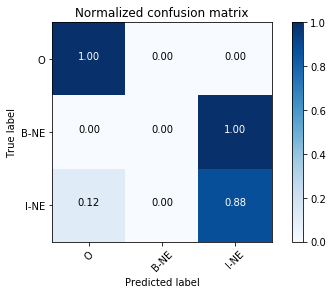

In [24]:
y_pred_en = model.predict(X_en_test)
score_en = model.evaluate(X_en_test, y_en_test_bin)
for i in range(len(score_en)):
    print(str(model.metrics_names[i]) + ': ' + str(score_en[i]))
y_pred_en_label = arr2label(y_pred_en, bin_classes)
y_true_en_label = arr2label(y_en_test_bin, bin_classes)

precision = precision_score(y_true_en_label, y_pred_en_label, average='macro')
recall = recall_score(y_true_en_label, y_pred_en_label, average='macro')
f1 = f1_score(y_true_en_label, y_pred_en_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_en_label, y_pred_en_label, labels=bin_classes)
plot_confusion_matrix(cnf_matrix, classes=bin_classes, normalize=True,
                      title='Normalized confusion matrix')

### Binary German Results from English Training

2644/2644 [==============================] - 19s 7ms/step
loss: 0.346411018978
acc: 0.873060296505


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: 0.38396588433
Recall: 0.518422123957
F1: 0.398472951092


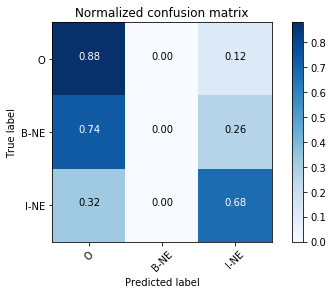

In [25]:
y_pred_de = model.predict(X_de_test)
score_de = model.evaluate(X_de_test, y_de_test_bin)
for i in range(len(score_de)):
    print(str(model.metrics_names[i]) + ': ' + str(score_de[i]))
y_pred_de_label = arr2label(y_pred_de, bin_classes)
y_true_de_label = arr2label(y_de_test_bin, bin_classes)

precision = precision_score(y_true_de_label, y_pred_de_label, average='macro')
recall = recall_score(y_true_de_label, y_pred_de_label, average='macro')
f1 = f1_score(y_true_de_label, y_pred_de_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_de_label, y_pred_de_label, labels=bin_classes)
plot_confusion_matrix(cnf_matrix, classes=bin_classes, normalize=True,
                      title='Normalized confusion matrix')

### Binary Spanish Results from English Training

1588/1588 [==============================] - 12s 7ms/step
loss: 0.498359407826
acc: 0.940770062602


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: 0.429978901325
Recall: 0.523701587674
F1: 0.463606866817


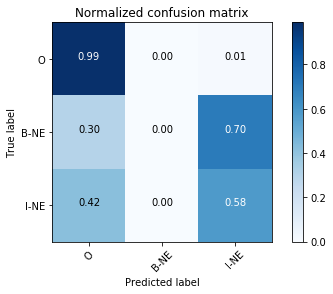

In [26]:
y_pred_es = model.predict(X_es_test)
score_es = model.evaluate(X_es_test, y_es_test_bin)
for i in range(len(score_es)):
    print(str(model.metrics_names[i]) + ': ' + str(score_es[i]))
y_pred_es_label = arr2label(y_pred_es, bin_classes)
y_true_es_label = arr2label(y_es_test_bin, bin_classes)

precision = precision_score(y_true_es_label, y_pred_es_label, average='macro')
recall = recall_score(y_true_es_label, y_pred_es_label, average='macro')
f1 = f1_score(y_true_es_label, y_pred_es_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_es_label, y_pred_es_label, labels=bin_classes)
plot_confusion_matrix(cnf_matrix, classes=bin_classes, normalize=True,
                      title='Normalized confusion matrix')

# Train on Every Language

In [27]:
print("X shape:", X_train.shape)
print("y shape:", y_train.shape)
model = create_model(num_classes, num_features)
model.fit(X_train, y_train, batch_size=50, epochs=10)

X shape: (29407, 70, 300)
y shape: (29407, 70, 9)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 70, 600)           1442400   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 70, 100)           60100     
_________________________________________________________________
crf_3 (CRF)                  (None, 70, 9)             1008      
Total params: 1,503,508
Trainable params: 1,503,508
Non-trainable params: 0
_________________________________________________________________
Summary: None
Epoch 1/10
29407/29407 [==============================] - 525s 18ms/step - loss: 0.1238 - acc: 0.9673
Epoch 2/10
29407/29407 [==============================] - 527s 18ms/step - loss: 0.0558 - acc: 0.9788
Epoch 3/10
29407/29407 [==============================] - 524s 18ms/step - loss: 0.0345 - acc: 0.9812
Epoch 4/10
29407/29407 [==

### Save the Model

In [28]:
save_load_utils.save_all_weights(model,'models/full_train.h5')

### English Results from Full Training

2701/2701 [==============================] - 22s 8ms/step
loss: -0.0588551258343
acc: 0.990389802177


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Precision: 0.508530929008
Recall: 0.458786689218
F1: 0.479443554989


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


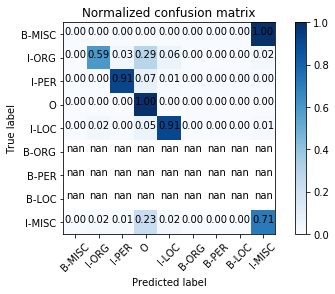

In [29]:
y_pred_en = model.predict(X_en_test)
score_en = model.evaluate(X_en_test, y_en_test)
for i in range(len(score_en)):
    print(str(model.metrics_names[i]) + ': ' + str(score_en[i]))
y_pred_en_label = arr2label(y_pred_en, classes)
y_true_en_label = arr2label(y_en_test, classes)

precision = precision_score(y_true_en_label, y_pred_en_label, average='macro')
recall = recall_score(y_true_en_label, y_pred_en_label, average='macro')
f1 = f1_score(y_true_en_label, y_pred_en_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_en_label, y_pred_en_label, labels=classes)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

### German Results from Full Training

2644/2644 [==============================] - 21s 8ms/step
loss: -0.00890190223917
acc: 0.979743894128


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Precision: 0.443658222427
Recall: 0.297580614638
F1: 0.342419763817


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


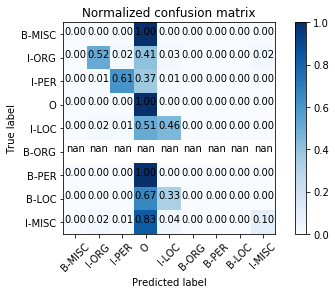

In [30]:
y_pred_de = model.predict(X_de_test)
score_de = model.evaluate(X_de_test, y_de_test)
for i in range(len(score_de)):
    print(str(model.metrics_names[i]) + ': ' + str(score_de[i]))
y_pred_de_label = arr2label(y_pred_de, classes)
y_true_de_label = arr2label(y_de_test, classes)

precision = precision_score(y_true_de_label, y_pred_de_label, average='macro')
recall = recall_score(y_true_de_label, y_pred_de_label, average='macro')
f1 = f1_score(y_true_de_label, y_pred_de_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_de_label, y_pred_de_label, labels=classes)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

### Spanish Results from Full Training

1588/1588 [==============================] - 12s 8ms/step
loss: -0.0231303376889
acc: 0.974577188942
Precision: 0.746526909234
Recall: 0.721938391152
F1: 0.726253893897


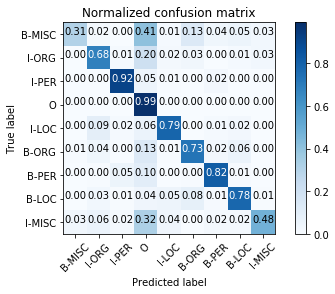

In [31]:
y_pred_es = model.predict(X_es_test)
score_es = model.evaluate(X_es_test, y_es_test)
for i in range(len(score_es)):
    print(str(model.metrics_names[i]) + ': ' + str(score_es[i]))
y_pred_es_label = arr2label(y_pred_es, classes)
y_true_es_label = arr2label(y_es_test, classes)

precision = precision_score(y_true_es_label, y_pred_es_label, average='macro')
recall = recall_score(y_true_es_label, y_pred_es_label, average='macro')
f1 = f1_score(y_true_es_label, y_pred_es_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_es_label, y_pred_es_label, labels=classes)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

## Binary Task with Full Training

In [32]:
print("X shape:", X_train.shape)
print("y shape:", y_train_bin.shape)
model = create_model(bin_num_classes, num_features)
model.fit(X_train, y_train_bin, batch_size=50, epochs=10)

X shape: (29407, 70, 300)
y shape: (29407, 70, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 70, 600)           1442400   
_________________________________________________________________
time_distributed_4 (TimeDist (None, 70, 100)           60100     
_________________________________________________________________
crf_4 (CRF)                  (None, 70, 3)             318       
Total params: 1,502,818
Trainable params: 1,502,818
Non-trainable params: 0
_________________________________________________________________
Summary: None
Epoch 1/10
29407/29407 [==============================] - 505s 17ms/step - loss: 0.0829 - acc: 0.9724
Epoch 2/10
29407/29407 [==============================] - 491s 17ms/step - loss: 0.0459 - acc: 0.9817
Epoch 3/10
29407/29407 [==============================] - 496s 17ms/step - loss: 0.0313 - acc: 0.9837
Epoch 4/10
29407/29407 [==

In [33]:
save_load_utils.save_all_weights(model,'models/full_train_bin.h5')

### Binary English Results from Full Training

2701/2701 [==============================] - 21s 8ms/step
loss: -0.0463379866787
acc: 0.991696194714
Precision: 0.648398777229
Recall: 0.614282812942
F1: 0.630274297615


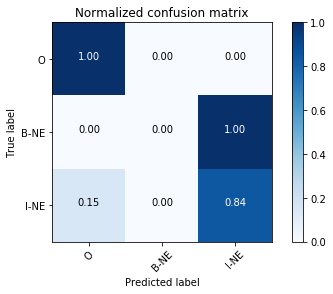

In [34]:
y_pred_en = model.predict(X_en_test)
score_en = model.evaluate(X_en_test, y_en_test_bin)
for i in range(len(score_en)):
    print(str(model.metrics_names[i]) + ': ' + str(score_en[i]))
y_pred_en_label = arr2label(y_pred_en, bin_classes)
y_true_en_label = arr2label(y_en_test_bin, bin_classes)

precision = precision_score(y_true_en_label, y_pred_en_label, average='macro')
recall = recall_score(y_true_en_label, y_pred_en_label, average='macro')
f1 = f1_score(y_true_en_label, y_pred_en_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_en_label, y_pred_en_label, labels=bin_classes)
plot_confusion_matrix(cnf_matrix, classes=bin_classes, normalize=True,
                      title='Normalized confusion matrix')

### Binary German Results from Full Training

2644/2644 [==============================] - 19s 7ms/step
loss: -0.00779850684027
acc: 0.981532312197
Precision: 0.627866314148
Recall: 0.503995523461
F1: 0.548311682933


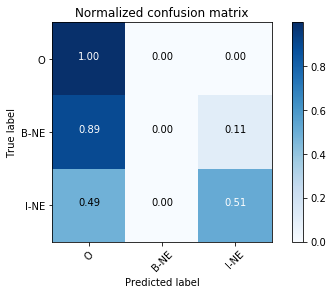

In [35]:
y_pred_de = model.predict(X_de_test)
score_de = model.evaluate(X_de_test, y_de_test_bin)
for i in range(len(score_de)):
    print(str(model.metrics_names[i]) + ': ' + str(score_de[i]))
y_pred_de_label = arr2label(y_pred_de, bin_classes)
y_true_de_label = arr2label(y_de_test_bin, bin_classes)

precision = precision_score(y_true_de_label, y_pred_de_label, average='macro')
recall = recall_score(y_true_de_label, y_pred_de_label, average='macro')
f1 = f1_score(y_true_de_label, y_pred_de_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_de_label, y_pred_de_label, labels=bin_classes)
plot_confusion_matrix(cnf_matrix, classes=bin_classes, normalize=True,
                      title='Normalized confusion matrix')

### Binary Spanish Results from Full Training

1588/1588 [==============================] - 12s 7ms/step
loss: -0.0127353477433
acc: 0.976709245885
Precision: 0.886204288122
Recall: 0.802587172022
F1: 0.837964154081


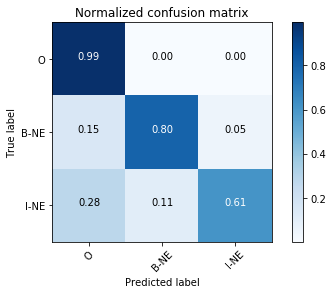

In [36]:
y_pred_es = model.predict(X_es_test)
score_es = model.evaluate(X_es_test, y_es_test_bin)
for i in range(len(score_es)):
    print(str(model.metrics_names[i]) + ': ' + str(score_es[i]))
y_pred_es_label = arr2label(y_pred_es, bin_classes)
y_true_es_label = arr2label(y_es_test_bin, bin_classes)

precision = precision_score(y_true_es_label, y_pred_es_label, average='macro')
recall = recall_score(y_true_es_label, y_pred_es_label, average='macro')
f1 = f1_score(y_true_es_label, y_pred_es_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_es_label, y_pred_es_label, labels=bin_classes)
plot_confusion_matrix(cnf_matrix, classes=bin_classes, normalize=True,
                      title='Normalized confusion matrix')